In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import from our utils file, including the NEW TransformerModel
from pytorch_utils import TimeSeriesDataset, TransformerModel 

### Clasification

In [2]:
# --- Step 1: Load CORRECT Data ---
print("Step 1: Loading session sequence data...")
X = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_sequences_X_padded.npy')
y = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_targets_y_class.npy') # Load the classification target
y_reg = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_targets_y_reg.npy') # Load the reg target


# --- Step 2: Create Datasets and DataLoaders ---
# For session-to-session prediction, a random split is acceptable.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataset_reg = TimeSeriesDataset(X_train, y_train_reg)
test_dataset_reg = TimeSeriesDataset(X_test, y_test_reg)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_loader_reg = DataLoader(train_dataset_reg, batch_size=64, shuffle=True)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=64, shuffle=False)
print("DataLoaders created.")

Step 1: Loading session sequence data...
DataLoaders created.


In [3]:
X[1],y[1]

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-1.08187971, -1.07766116, -1.07921718, -1.07819699,  0.3234584 ],
        [-1.07824367, -1.07938434, -1.08074401, -1.08199787, -0.51209084],
        [-1.08211844, -1.08327066, -1.08352175, -1.08521117, -0.31578005],
        [-1.08529538, -1.08772527, -1.0874768 , -1.08871825,  0.22308018],
        [-1.08876614, -1.09010839, -1.09240682, -1.09251912,  0.64190772],
        [-1.09256745, -1.09355475, -1.09093517, -1.092868  , -0.00411621],
        [-1.09291636, -1.09474631, -1.09187334, -1.09244568, -0.44493804],
        [-1.09249399, -1.0926565 , -1.08988662, -1.09101346, -0.47441976],
        [-1.09106162, -1.08939345, -1.08916919, -1.08717587, -0.11736343]]),
 np.int64(1))

In [4]:
X.shape

(1995, 10, 5)

In [5]:
# --- Step 3: Initialize Transformer Model, Loss, and Optimizer ---
input_size = X.shape[2]    # Num features per hour (5)
hidden_size = 32           # The "embedding dimension". Must be divisible by nhead.
nhead = 4                  # Number of "attention heads". 4 or 8 is common.
nlayers = 2                # Number of transformer layers to stack.
output_size = 1

# Initialize our NEW model
model = TransformerModel(input_size, hidden_size, nhead, nlayers, output_size)

# The loss and optimizer are the same as for the LSTM classifier
criterion = nn.BCEWithLogitsLoss()
criterion_reg = nn.L1Loss() # This is the standard for reg

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Transformer Model, Loss, and Optimizer initialized.")

Transformer Model, Loss, and Optimizer initialized.


In [6]:
# --- Step 4: The Training Loop ---
print("\nStep 4: Starting training loop...")
num_epochs = 100
model_class = model
for epoch in range(num_epochs):
    model_class.train()
    for batch_X, batch_y in train_loader:
        outputs = model_class(batch_X).squeeze() # Get model output
        loss = criterion(outputs, batch_y.float()) # Compare with target

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished.")


Step 4: Starting training loop...
Epoch [1/100], Loss: 0.7163
Epoch [2/100], Loss: 0.6844
Epoch [3/100], Loss: 0.6966
Epoch [4/100], Loss: 0.6759
Epoch [5/100], Loss: 0.6916
Epoch [6/100], Loss: 0.7218
Epoch [7/100], Loss: 0.6961
Epoch [8/100], Loss: 0.6898
Epoch [9/100], Loss: 0.7020
Epoch [10/100], Loss: 0.6910
Epoch [11/100], Loss: 0.6976
Epoch [12/100], Loss: 0.6955
Epoch [13/100], Loss: 0.6957
Epoch [14/100], Loss: 0.6809
Epoch [15/100], Loss: 0.7029
Epoch [16/100], Loss: 0.6984
Epoch [17/100], Loss: 0.6933
Epoch [18/100], Loss: 0.6950
Epoch [19/100], Loss: 0.6860
Epoch [20/100], Loss: 0.6997
Epoch [21/100], Loss: 0.7210
Epoch [22/100], Loss: 0.6936
Epoch [23/100], Loss: 0.6930
Epoch [24/100], Loss: 0.6809
Epoch [25/100], Loss: 0.6935
Epoch [26/100], Loss: 0.6887
Epoch [27/100], Loss: 0.6990
Epoch [28/100], Loss: 0.6892
Epoch [29/100], Loss: 0.6846
Epoch [30/100], Loss: 0.7008
Epoch [31/100], Loss: 0.7022
Epoch [32/100], Loss: 0.6956
Epoch [33/100], Loss: 0.6979
Epoch [34/100], L


--- Evaluating Model with Detailed Metrics ---

--- Classification Report ---
              precision    recall  f1-score   support

 Bearish (0)       0.50      0.27      0.35       201
 Bullish (1)       0.49      0.73      0.59       198

    accuracy                           0.50       399
   macro avg       0.50      0.50      0.47       399
weighted avg       0.50      0.50      0.47       399


--- Confusion Matrix ---


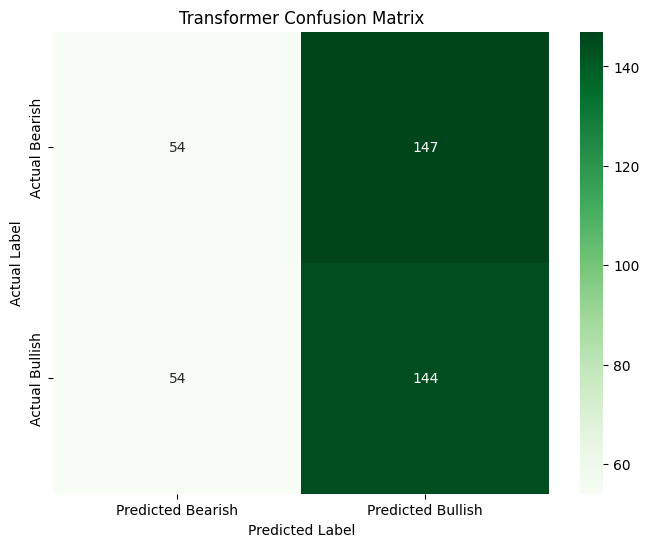

In [ ]:
# REPLACE your old "Step 5" in src/train_pytorch.py with this new section

# --- Step 5: Detailed Evaluation on Test Set ---
print("\n--- Evaluating Model with Detailed Metrics ---")
model_class.eval() # Set the model to evaluation mode (very important!)

# We need to collect all predictions and true labels from the test set
all_predictions = []
all_labels = []

# torch.inference_mode() tells PyTorch we are not training, so it doesn't need to calculate gradients.
# This makes evaluation much faster and uses less memory.
with torch.inference_mode():
    for batch_X, batch_y in test_loader:
        # 1. Get the raw model output (logits)
        outputs = model_class(batch_X).squeeze()
        
        # 2. Convert logits to final predictions (0 or 1)
        predicted = torch.round(torch.sigmoid(outputs))
        
        # 3. Move predictions and labels to the CPU and convert to NumPy arrays
        #    so that scikit-learn can use them.
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# --- 5a. Generate the Classification Report ---
print("\n--- Classification Report ---")
# This report gives you precision, recall, and f1-score for each class.
report = classification_report(all_labels, all_predictions, target_names=['Bearish (0)', 'Bullish (1)'])
print(report)

# --- 5b. Generate and Visualize the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_predictions)

# Use seaborn to create a nice heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicted Bearish', 'Predicted Bullish'], 
            yticklabels=['Actual Bearish', 'Actual Bullish'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Transformer Confusion Matrix')
plt.show()

In [8]:
# --- Step 6: Save the Model --- (This part is unchanged)
model_path = '../models/hyp_a_xauusd_h1_2018_pytorch_transformer_classifier_50acc_49p_73r.pth'
torch.save(model_class.state_dict(), model_path)
print(f"\nClassification model saved to {model_path}")


Classification model saved to ../models/hyp_a_xauusd_h1_2018_pytorch_transformer_classifier_50acc_49p_73r.pth


### reg training

In [9]:
# --- Step 4: The Training Loop ---
print("\nStep 4: Starting training loop...")
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader_reg:
        outputs = model(batch_X).squeeze() # Get model output
        loss = criterion_reg(outputs, batch_y.float()) # Compare with target

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished.")


Step 4: Starting training loop...
Epoch [1/100], Loss: 0.0074
Epoch [2/100], Loss: 0.0127
Epoch [3/100], Loss: 0.0053
Epoch [4/100], Loss: 0.0043
Epoch [5/100], Loss: 0.0055
Epoch [6/100], Loss: 0.0056
Epoch [7/100], Loss: 0.0054
Epoch [8/100], Loss: 0.0051
Epoch [9/100], Loss: 0.0050
Epoch [10/100], Loss: 0.0053
Epoch [11/100], Loss: 0.0047
Epoch [12/100], Loss: 0.0046
Epoch [13/100], Loss: 0.0048
Epoch [14/100], Loss: 0.0047
Epoch [15/100], Loss: 0.0045
Epoch [16/100], Loss: 0.0042
Epoch [17/100], Loss: 0.0049
Epoch [18/100], Loss: 0.0045
Epoch [19/100], Loss: 0.0046
Epoch [20/100], Loss: 0.0047
Epoch [21/100], Loss: 0.0039
Epoch [22/100], Loss: 0.0046
Epoch [23/100], Loss: 0.0048
Epoch [24/100], Loss: 0.0054
Epoch [25/100], Loss: 0.0050
Epoch [26/100], Loss: 0.0058
Epoch [27/100], Loss: 0.0046
Epoch [28/100], Loss: 0.0039
Epoch [29/100], Loss: 0.0046
Epoch [30/100], Loss: 0.0042
Epoch [31/100], Loss: 0.0043
Epoch [32/100], Loss: 0.0046
Epoch [33/100], Loss: 0.0038
Epoch [34/100], L

In [ ]:
# --- Step 5: Evaluation for REGRESSION ---
model.eval()
total_mae = 0.0
with torch.inference_mode():
    for batch_X, batch_y in test_loader_reg:
        outputs = model(batch_X).squeeze()
        # CHANGE: We directly calculate the MAE. No sigmoid, no rounding.
        mae = criterion(outputs, batch_y.float())
        total_mae += mae.item() * batch_X.size(0)

avg_mae = total_mae / len(test_dataset)
print(f'\nMean Absolute Error (MAE) on test data: {avg_mae:.6f}')
print("This means our model's return prediction is off by this amount on average.")


Mean Absolute Error (MAE) on test data: 0.694170
This means our model's return prediction is off by this amount on average.


In [12]:
# --- Step 6: Save the Model ---
model_path = '../models/hyp_a_xauusd_h1_2018_pytorch_transformer_regressor_0694_mae.pth'
torch.save(model.state_dict(), model_path)
print(f"Regression model saved to {model_path}")

Regression model saved to ../models/hyp_a_xauusd_h1_2018_pytorch_transformer_regressor_0694_mae.pth
